In [41]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import LogNorm
import os
import seaborn as sns
import scipy.stats
import statsmodels.stats.multitest
import pandas as pd

eur = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/EUR_eSTR_regression.csv", sep="\t")
afr = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/AFR_eSTR_regression.csv", sep="\t")

# basic filtering
eur = eur[(eur["sample_n"]>=50) & (~np.isnan(eur["p_values"]))]
afr = afr[(afr["sample_n"]>=50) & (~np.isnan(afr["p_values"]))]

Populating the interactive namespace from numpy and matplotlib


# Get numbers significant

In [78]:
FDRTHRESH = 0.05

def GetGeneLevelFDR(df, fdrthresh=0.05, prefix=None):
    # Get best pval per gene, and adjustment factor
    bygene = df.groupby(["gene_name"], as_index=False).agg({"str-gene": len})
    # Bonferroni adjusted for number of STRs tested
    bygene = bygene.rename({"str-gene": "num.strs.tested"}, axis=1)
    # merge back to main df
    xx = pd.merge(df, bygene[["gene_name","num.strs.tested"]], on=["gene_name"], how="outer")
    # Bonferonni adjustment of pvalues
    xx["genelevel.bf.adj.p"] = xx.apply(lambda x: np.min([1, x["p_values"]*x["num.strs.tested"]]), 1)
    # Find the best STR per gene and do FDR on that
    bestps = xx.groupby(["gene_name"], as_index=False).agg({"genelevel.bf.adj.p": np.min})
    bestps["genelevel.p.adj"] = \
        statsmodels.stats.multitest.multipletests(list(bestps["genelevel.bf.adj.p"]), \
                                                  method="fdr_bh")[1]
    bestps = bestps.rename({"genelevel.p.adj": "best.genelevel.p.adj", 
                           "genelevel.bf.adj.p": "best.genelevel.bf.adj.p"}, axis=1)
    # Merge back to the main one
    xx = pd.merge(xx, bestps, on=["gene_name"])
    xx["best.str"] = (xx["genelevel.bf.adj.p"]==xx["best.genelevel.bf.adj.p"])
    # Determine significance
    xx["sig.genelevel"] = xx.apply(lambda x: x["best.str"] and (x["best.genelevel.p.adj"]<fdrthresh), 1)
    print("Identified %s eSTRs at gene-level FDR (%s): %s"%(np.sum(xx["sig.genelevel"]), prefix, fdrthresh))
    return xx

########### Not collapsed by gene #############################
eur["p.adj"] = statsmodels.stats.multitest.multipletests(list(eur["p_values"]), method="fdr_bh")[1]
afr["p.adj"] = statsmodels.stats.multitest.multipletests(list(afr["p_values"]), method="fdr_bh")[1]

print("Num eSTR - EUR: %s"%eur[eur["p.adj"]<FDRTHRESH].shape[0])
print("Num eSTR - AFR: %s"%afr[afr["p.adj"]<FDRTHRESH].shape[0])

########### Gene-level FDR ####################################
eur_fdr = GetGeneLevelFDR(eur, prefix="EUR")
afr_fdr = GetGeneLevelFDR(afr, prefix="AFR")

Num eSTR - EUR: 55707
Num eSTR - AFR: 408
Identified 3665 eSTRs at gene-level FDR (EUR): 0.05
Identified 85 eSTRs at gene-level FDR (AFR): 0.05


In [74]:
# Merge for comparison
cols = ["str-gene", "gene_name", "sample_n","p_values","slope","error","p.adj","best.str","sig.genelevel","best.genelevel.p.adj"]
data = pd.merge(eur_fdr[cols], afr_fdr[cols], on=["str-gene","gene_name"], suffixes=("_EUR", "_AFR"), how="outer")

# Compare AFR vs. EUR effects

6.387425458744897e-08
(0.6465304238554547, 0.0)


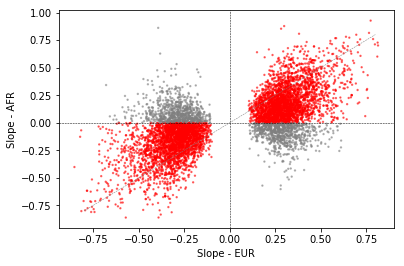

In [77]:
PTHRESH = 0.05/data.shape[0]
print(PTHRESH)
pltdata = data[(data["p.adj_EUR"]<PTHRESH) | (data["p.adj_AFR"]<PTHRESH)]
pltdata = pltdata[pltdata["slope_AFR"].apply(abs) < 1]
pltdata = pltdata[pltdata["slope_EUR"].apply(abs) < 1]

def GetColor(x):
    if np.sign(x["slope_EUR"])==np.sign(x["slope_AFR"]):
        return "red"
    else: return "gray"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pltdata["slope_EUR"], pltdata["slope_AFR"], color=pltdata.apply(GetColor, 1), s=2, alpha=0.5);
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
ax.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=0.5)
ax.set_xlabel("Slope - EUR")
ax.set_ylabel("Slope - AFR");
print(scipy.stats.pearsonr(pltdata["slope_EUR"], pltdata["slope_AFR"]))

# Compare to GTEx

In [103]:
TISSUES = [
    "Adipose-Subcutaneous",
    "Adipose-Visceral",
    "Artery-Aorta",
    "Artery-Tibial",
    "Brain-Caudate",
    "Brain-Cerebellum",
    "Cells-Transformedfibroblasts",
    "Esophagus-Mucosa",
    "Esophagus-Muscularis",
    "Heart-LeftVentricle",
    "Lung",
    "Muscle-Skeletal",
    "Nerve-Tibial",
    "Skin-NotSunExposed",
    "Skin-SunExposed",
    "Thyroid",
    "WholeBlood"
]

###### Load GTEx data ###########
gtex = {} # tissue -> df
for t in TISSUES:
    df = pd.read_csv("raw/master/%s_master.tab"%t, sep="\t")
    lift = pd.read_csv("liftover/%s_hg38.bed"%t, sep="\t", names=["chrom","start_hg38","x","hg19_coords"])
    lift["str.start"] = lift["hg19_coords"].apply(lambda x: int(x.split(":")[1]))
    lift = lift.drop_duplicates()
    df = pd.merge(df, lift[["chrom","str.start","start_hg38"]], on=["chrom","str.start"])
    df = df.rename({"gene.name": "gene_name"}, axis=1)
    df["linreg.pval.adj"] = statsmodels.stats.multitest.multipletests(list(df["linreg.pval"]), \
                                                  method="fdr_bh")[1]
    gtex[t] = df

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/stats/multitest.py:326: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [90]:
eur_fdr["start_hg38"] = eur_fdr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
eur_fdr["chrom"] = eur_fdr["str-gene"].apply(lambda x: x.split("_")[0])

afr_fdr["start_hg38"] = afr_fdr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
afr_fdr["chrom"] = afr_fdr["str-gene"].apply(lambda x: x.split("_")[0])

In [ ]:
def MergeGTExGeuvadis(gtex, geu):
    # Round coordinates in case off by a bit
    R = 20
    geu["start_hg38_rounded"] = geu["start_hg38"].apply(lambda x: int(x/R)*R)
    gtex["start_hg38_rounded"] = gtex["start_hg38"].apply(lambda x: int(x/R)*R)
    # Merge on rounded coords and gene
    merged = pd.merge(geu[["chrom","start_hg38_rounded","gene_name","slope","p_values","p.adj"]], \
                        gtex[["chrom","start_hg38_rounded","gene_name","linreg.beta","linreg.pval","linreg.pval.adj"]])
    merged = merged[~np.isnan(merged["linreg.beta"]) & ~np.isnan(merged["slope"])]
    
    # Require some significance threshold in either
    merged = merged[(merged["p.adj"]<FDRTHRESH) | (merged["linreg.pval.adj"]<FDRTHRESH)]
    return merged

for t in TISSUES:
    eur_merged = MergeGTExGeuvadis(gtex[t], eur_fdr)
    afr_merged = MergeGTExGeuvadis(gtex[t], afr_fdr)
    
    print("##### %s ########"%t)
    r_eur, p_eur = scipy.stats.pearsonr(eur_merged["slope"], eur_merged["linreg.beta"])
    print("EUR n=%s r=%.2f p=%.2g"%(eur_merged.shape[0]), r_eur, p_eur)
    r_afr, p_afr = scipy.stats.pearsonr(afr_merged["slope"], afr_merged["linreg.beta"])
    print("AFR n=%s r=%.2f p=%.2g"%(afr_merged.shape[0]), r_afr, p_afr)
